In [1]:
import sys
import subprocess
import json
import gzip
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import transforms


sys.path.append(os.path.abspath("../generation"))
import generate
from parseRePEAT import *

In [2]:
def plot_atf(segments):
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            plt.hlines(float(y1), 0, float(x1), colors="red")
        plt.plot([float(x0), float(x1)], [float(y0), float(y1)], color='red')
    plt.xlabel("Departure time (s)")
    plt.ylabel("Arrival time (s)")
    plt.show()

[('-inf', '616.2', '1046.2', '1046.2'), ('616.2', '800.5', '1046.2', '1230.5'), ('800.5', '1296.2', '1726.2', '1726.2'), ('1296.2', '1400.5', '1726.2', '1830.5'), ('1400.5', '1896.2', '2326.2', '2326.2'), ('1896.2', '2370', '2326.2', '2800'), ('2370', 'inf', 'inf', 'inf')]


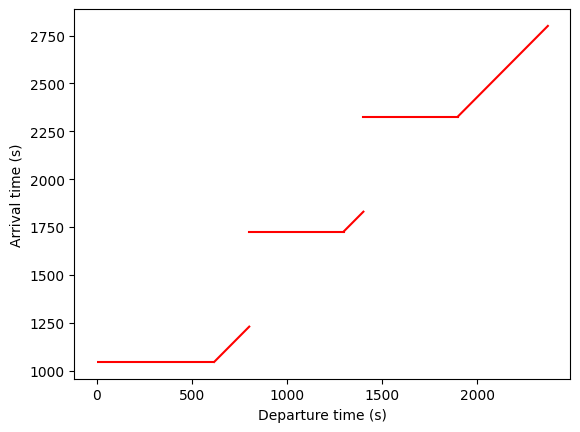

[('-inf', '616.2', '1046.2', '1046.2'), ('616.2', '800.5', '1046.2', '1230.5'), ('800.5', '1296.2', '1726.2', '1726.2'), ('1296.2', '1400.5', '1726.2', '1830.5'), ('1400.5', '1896.2', '2326.2', '2326.2'), ('1896.2', '2370', '2326.2', '2800'), ('2370', 'inf', 'inf', 'inf')]


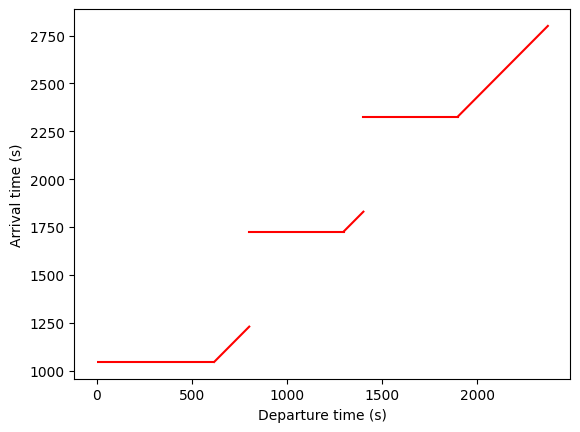

[('-inf', '616.2', '1046.2', '1046.2'), ('616.2', '800.5', '1046.2', '1230.5'), ('800.5', '1296.2', '1726.2', '1726.2'), ('1296.2', '1400.5', '1726.2', '1830.5'), ('1400.5', '1896.2', '2326.2', '2326.2'), ('1896.2', '2370', '2326.2', '2800'), ('2370', 'inf', 'inf', 'inf')]


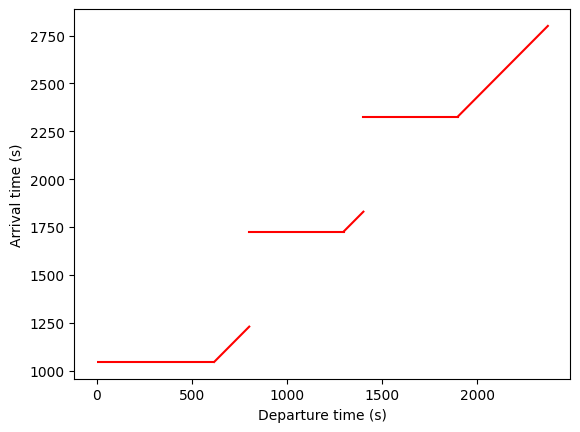

In [11]:
# Run RePeAT to get multiple plans
scenario = "../data/custom/scenario_small_custom.json"
layout =   "../data/custom/meppel_leeuwarden_single.json"

scenario_data = json.load(open(scenario))
train_types = {x["name"]: x for x in scenario_data["types"]}
for agent in scenario_data['trains']:
    # Get the global end time of scenario
    scenario_end_time = 0
    for i in range(len(agent["movements"])):
        move = agent["movements"][i]
        if 2 * move["endTime"] > scenario_end_time:
            scenario_end_time = 2 * move["endTime"]
    # agent_speed = train_types[agent["trainUnitTypes"][0]]["speed"]
    agent_speed = 80
    for move in agent["movements"]:
        # Generate intervals
        generation_time = generate.time_safe_intervals_and_write(layout, scenario, -1, agent_speed, "output")
        safe_interval_output = [str(x).split("'")[1] for x in gzip.open("output").readlines()]
        try:
            proc = subprocess.run(["atsipp.exe", "--start", "r-270", "--goal", "r-96", "--edgegraph", "output", "--search", "repeat", "--startTime", "200", "--agentSpeed", str(agent_speed), "--walkingSpeed", str(scenario_data["walkingSpeed"])], timeout=300, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        except subprocess.TimeoutExpired:
            print(f'Timeout for repeat (300s) expired')
        repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")
        try:
            all_lookups = [(int(x.split(" ")[1].strip(")").split("=")[1]), float(x.split(" ")[4])) for x in repeat_output if "Lookup time" in x]
            # Divide by number of lookups provided: Total (n=<x>) Lookup time: <y> nanoseconds
            lookup_time = mean([y / x for x, y in all_lookups])
        except: lookup_time = np.nan

        # If the run was successful
        if int(proc.returncode) == 0:
            search_time = [float(x.split(" ")[2]) for x in repeat_output if "Search time" in x][0]
            metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
            print(catf)
            plot_atf(catf)
